##  1 Import the Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.impute import SimpleImputer


#import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## 2 Read the Training Dataset from Local Machine and save it in Dataframe

In [2]:
WiDS = pd.read_csv("H:\WiDS Datathon 2021\TrainingWiDS2021.csv")

#### 2.1 Inspect the first Few rows of Dataframe to see if the file laoded and saved Successfully

In [3]:
WiDS.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


## 3 Data preprocessing and Exploeratory Data Analysis

#### 3.1 Inspect the Number of Rows and Columns


In [4]:
WiDS.shape

(130157, 181)

#### 3.2 Identifier column do not have any sif=gnificance in Model Building so we caan drop those


In [5]:
WiDS.filter(regex='_id').columns

Index(['encounter_id', 'hospital_id', 'icu_id'], dtype='object')

#### 3.3 The identifier columns do not having any influence on Target Variable,this can be dropped 

In [6]:
WiDS.drop(list(WiDS.filter(regex = '_id')), axis = 1, inplace = True)

In [7]:
WiDS = WiDS.drop([WiDS.columns[0]] ,  axis='columns')

#### 3.4 Column readmission_status has only one unique value so column can be dropped from Dataframe

In [8]:
WiDS['readmission_status'].unique()
WiDS.drop("readmission_status", axis=1, inplace=True)

#### 3.5 According to the data dictionary, the _apache variables are  measured during the first 24 hours which results in the highestAPACHE III score and  d1_..._max is the highest concentration of the patient during the first 24 hours of their unit stayTherefore, we could assume that the _apache and the d1_..._max values should be similar to each other

In [9]:
WiDS.d1_albumin_max.fillna(WiDS.albumin_apache, inplace=True)
WiDS.d1_bilirubin_max.fillna(WiDS.bilirubin_apache, inplace=True)
WiDS.d1_bun_max.fillna(WiDS.bun_apache, inplace=True)
WiDS.d1_creatinine_max.fillna(WiDS.creatinine_apache, inplace=True)
WiDS.d1_glucose_max.fillna(WiDS.glucose_apache, inplace=True)
WiDS.d1_hematocrit_max.fillna(WiDS.hematocrit_apache, inplace=True)
WiDS.d1_heartrate_max.fillna(WiDS.heart_rate_apache, inplace=True)
WiDS.d1_resprate_max.fillna(WiDS.resprate_apache, inplace=True)
WiDS.d1_wbc_max.fillna(WiDS.wbc_apache, inplace=True)
WiDS.d1_sodium_max.fillna(WiDS.sodium_apache, inplace=True)

# Drop ..._apache column
WiDS.drop('albumin_apache', axis=1, inplace=True)
WiDS.drop('bilirubin_apache', axis=1, inplace=True)
WiDS.drop('bun_apache', axis=1, inplace=True)
WiDS.drop('creatinine_apache', axis=1, inplace=True)
WiDS.drop('glucose_apache', axis=1, inplace=True)
WiDS.drop('hematocrit_apache', axis=1, inplace=True)
WiDS.drop('heart_rate_apache', axis=1, inplace=True)
WiDS.drop('resprate_apache', axis=1, inplace=True)
WiDS.drop('wbc_apache', axis=1, inplace=True)
WiDS.drop('sodium_apache', axis=1, inplace=True)

#### 3.6 The Glasgow Coma Scale (GCS) is a metric to measure a person's level of consciousness. It is based on the person's eye response, verbal response and motor response and ranges from 0 (unconscious) to 15 (fully conscious).

In [10]:
WiDS["gcs_sum_apache"] = WiDS[['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']].sum(axis=1)

WiDS.drop('gcs_eyes_apache', axis=1, inplace=True)
WiDS.drop('gcs_motor_apache', axis=1, inplace=True)
WiDS.drop('gcs_verbal_apache', axis=1, inplace=True)

#### 3.7 Check for the columns in the Dataset which has 70% or more NA values and drop the identified columns

In [11]:
WiDS.columns[WiDS.apply(lambda col: col.isnull().sum()/len(WiDS) > 0.70)]

Index(['fio2_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache',
       'ph_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min',
       'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_sysbp_invasive_max',
       'd1_sysbp_invasive_min', 'h1_diasbp_invasive_max',
       'h1_diasbp_invasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'd1_lactate_max',
       'd1_lactate_min', 'h1_albumin_max', 'h1_albumin_min',
       'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min',
       'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max',
       'h1_creatinine_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max',
       'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min',
       'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max',
       'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min',
       'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min',
       'd1_pao

In [12]:
WiDS = WiDS.drop(WiDS.columns[WiDS.apply(lambda col: col.isnull().sum()/len(WiDS) > 0.70)], axis=1)

#### 3.8 Impute the Missing values for Categorical Variables and convert column to categorical in pandas python using categorical() function

In [13]:
WiDS['ethnicity'].fillna('Unknown', inplace=True)
WiDS['gender'].fillna('Unknown', inplace=True)
WiDS['hospital_admit_source'].fillna('Emergency Department', inplace=True)
WiDS['icu_admit_source'].fillna('Emergency Department', inplace=True)
WiDS['icu_stay_type'].fillna('admit', inplace=True)
WiDS['icu_type'].fillna('Med-Surg ICU', inplace=True)

In [14]:
WiDS['ethnicity'] = pd.Categorical(WiDS.ethnicity)
WiDS['gender'] = pd.Categorical(WiDS.gender)
WiDS['hospital_admit_source'] = pd.Categorical(WiDS.hospital_admit_source)
WiDS['icu_admit_source'] = pd.Categorical(WiDS.hospital_admit_source)
WiDS['icu_stay_type'] = pd.Categorical(WiDS.icu_stay_type)
WiDS['icu_type'] = pd.Categorical(WiDS.icu_type)

#### 3.9 Impute Missing value for the Numeric Values

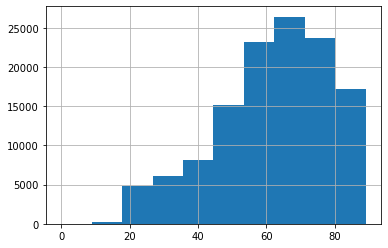

In [15]:
WiDS['age'].hist()
WiDS['age'] = WiDS['age'].groupby([WiDS['gender']]).apply(lambda x: x.fillna(x.median()))

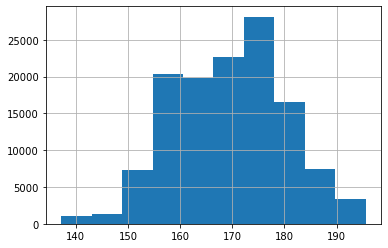

In [16]:
WiDS['height'].hist()
WiDS['height'] = WiDS['height'].groupby([WiDS['gender']]).apply(lambda x: x.fillna(x.mean()))

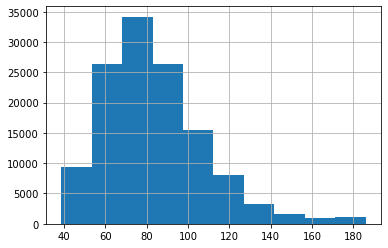

In [17]:
WiDS['weight'].hist()
WiDS['weight'] = WiDS['weight'].groupby([WiDS['gender']]).apply(lambda x: x.fillna(x.median()))

In [18]:
WiDS['bmi'] = WiDS['bmi'].fillna(WiDS.weight / (WiDS.height*WiDS.height))

#### 3.10 Visualize the Missing columns in the Dataframe after dropping the column having 70% or more Misssing Values

<AxesSubplot:>

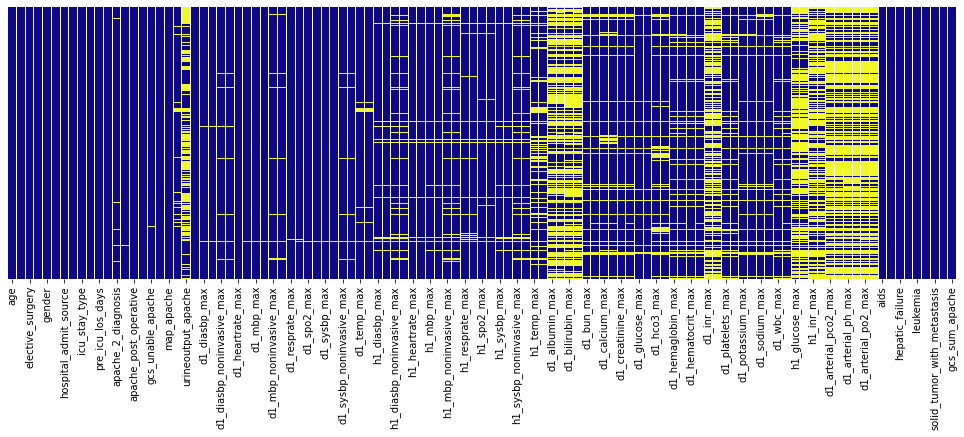

In [19]:
plt.figure(figsize=(17,5))
sns.heatmap(WiDS.isnull(), cbar=False, cmap= "plasma", yticklabels=False)

#### 3.11 Categorical encoding using Label-Encoding 

In [20]:
category_variables = ['gender', 'ethnicity']

from sklearn.preprocessing import LabelEncoder   
le = LabelEncoder()  
for category in category_variables:
    WiDS[category] = le.fit_transform(WiDS[category]) 

#### 3.12 Drop the columns 'hospital_admit_source','icu_admit_source','icu_stay_type', 'icu_type'

In [21]:
WiDS.drop(['hospital_admit_source','icu_admit_source','icu_stay_type', 'icu_type'], axis=1, inplace=True)

#### 3.13 Impute Missing value with Mean for all the Numeric Column

In [22]:
numeric_column = WiDS.columns[WiDS.select_dtypes(include=np.number).isna().any()].tolist()

In [23]:
for numeric_column_name in numeric_column:
    WiDS[numeric_column_name].fillna(WiDS[numeric_column_name].mean(),inplace=True)

#### 3.14 Visualize for any Missing value in dataframe column after imputation

<AxesSubplot:>

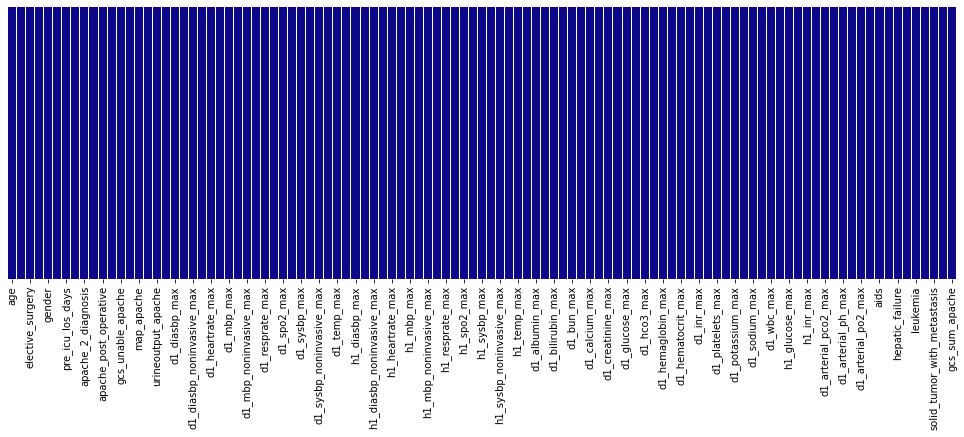

In [24]:
plt.figure(figsize=(17,5))
sns.heatmap(WiDS.isnull(), cbar=False, cmap= "plasma", yticklabels=False)

#### 3.15 Understanding the Target Vraiable

In [25]:
WiDS['diabetes_mellitus'].value_counts(ascending=True)

1     28151
0    102006
Name: diabetes_mellitus, dtype: int64

#### we can see disproportionate in ratio of observations in each class. we have to do a Resampling Techniques — Oversample minority class

In [26]:
# separate minority and majority classes
not_diabetes_mellitus = WiDS[WiDS.diabetes_mellitus==0]
diabetes_mellitus = WiDS[WiDS.diabetes_mellitus==1]

# upsample minority
diabetes_mellitus_upsampled = resample(diabetes_mellitus,
                          replace=True, # sample with replacement
                          n_samples=len(not_diabetes_mellitus), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
WiDS_upsampled = pd.concat([not_diabetes_mellitus, diabetes_mellitus_upsampled])

In [27]:
# Separate input features and target
y = WiDS_upsampled.diabetes_mellitus
x = WiDS_upsampled.drop('diabetes_mellitus', axis=1)

In [28]:
x.shape

(204012, 104)

## 4 Model Building : Build the First Model : Logistic Regression Algorithm

#### 4.1  Split the Data into Train and Test and upsample the Minoriy class

In [29]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

#### 4.2 Try logistic regression again with the balanced dataset

In [30]:
#lets start buliding the model
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()

#### 4.3 Predict on train data

In [31]:
log_reg.fit(X_train,y_train)
pred_train=log_reg.predict(X_train)
pd.crosstab(y_train,pred_train)

C:\Users\Abhilash\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


col_0,0,1
diabetes_mellitus,,
0,59353,17152
1,22286,54218


#### 4.4 Accuarcy on the train data

In [32]:
TP=53947
TN=59230
accuracy= float((TP+TN)/len(y_train))
print(accuracy)

0.739675443928135


#### 4.5 Make Predictions on Test Data

In [33]:
pred_test=log_reg.predict(X_test)
pd.crosstab(y_test,pred_test)

col_0,0,1
diabetes_mellitus,,
0,19778,5723
1,7462,18040


#### 4.6 Accuarcy on the test data

In [34]:
TP=18035
TN=19765
accuracy= float((TP+TN)/len(y_test))
print(accuracy)

0.741132874536792


#### 4.7 ROC Curve for the First Model

In [35]:
from sklearn.metrics import roc_auc_score
# lets measure the logistic model AUC
logistic_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test)) 
logistic_roc_auc

0.7414864633642133

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])

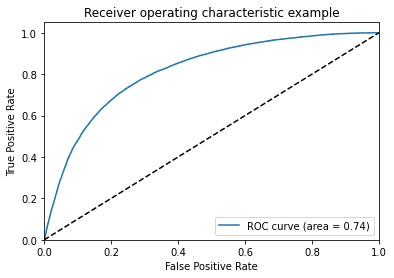

Logistic AUC = 0.74 


In [37]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % logistic_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc ="lower right")
plt.show()
print("Logistic AUC = %2.2f " % logistic_roc_auc )

## 5 Model Building : Calculate VIF to Identify the Significant Variable and Build a Second Logistic Regression Model

In [38]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, max_features = 20) # sampling with rows and with columns
classifier.fit(X_train,y_train)

RandomForestClassifier(max_features=20)

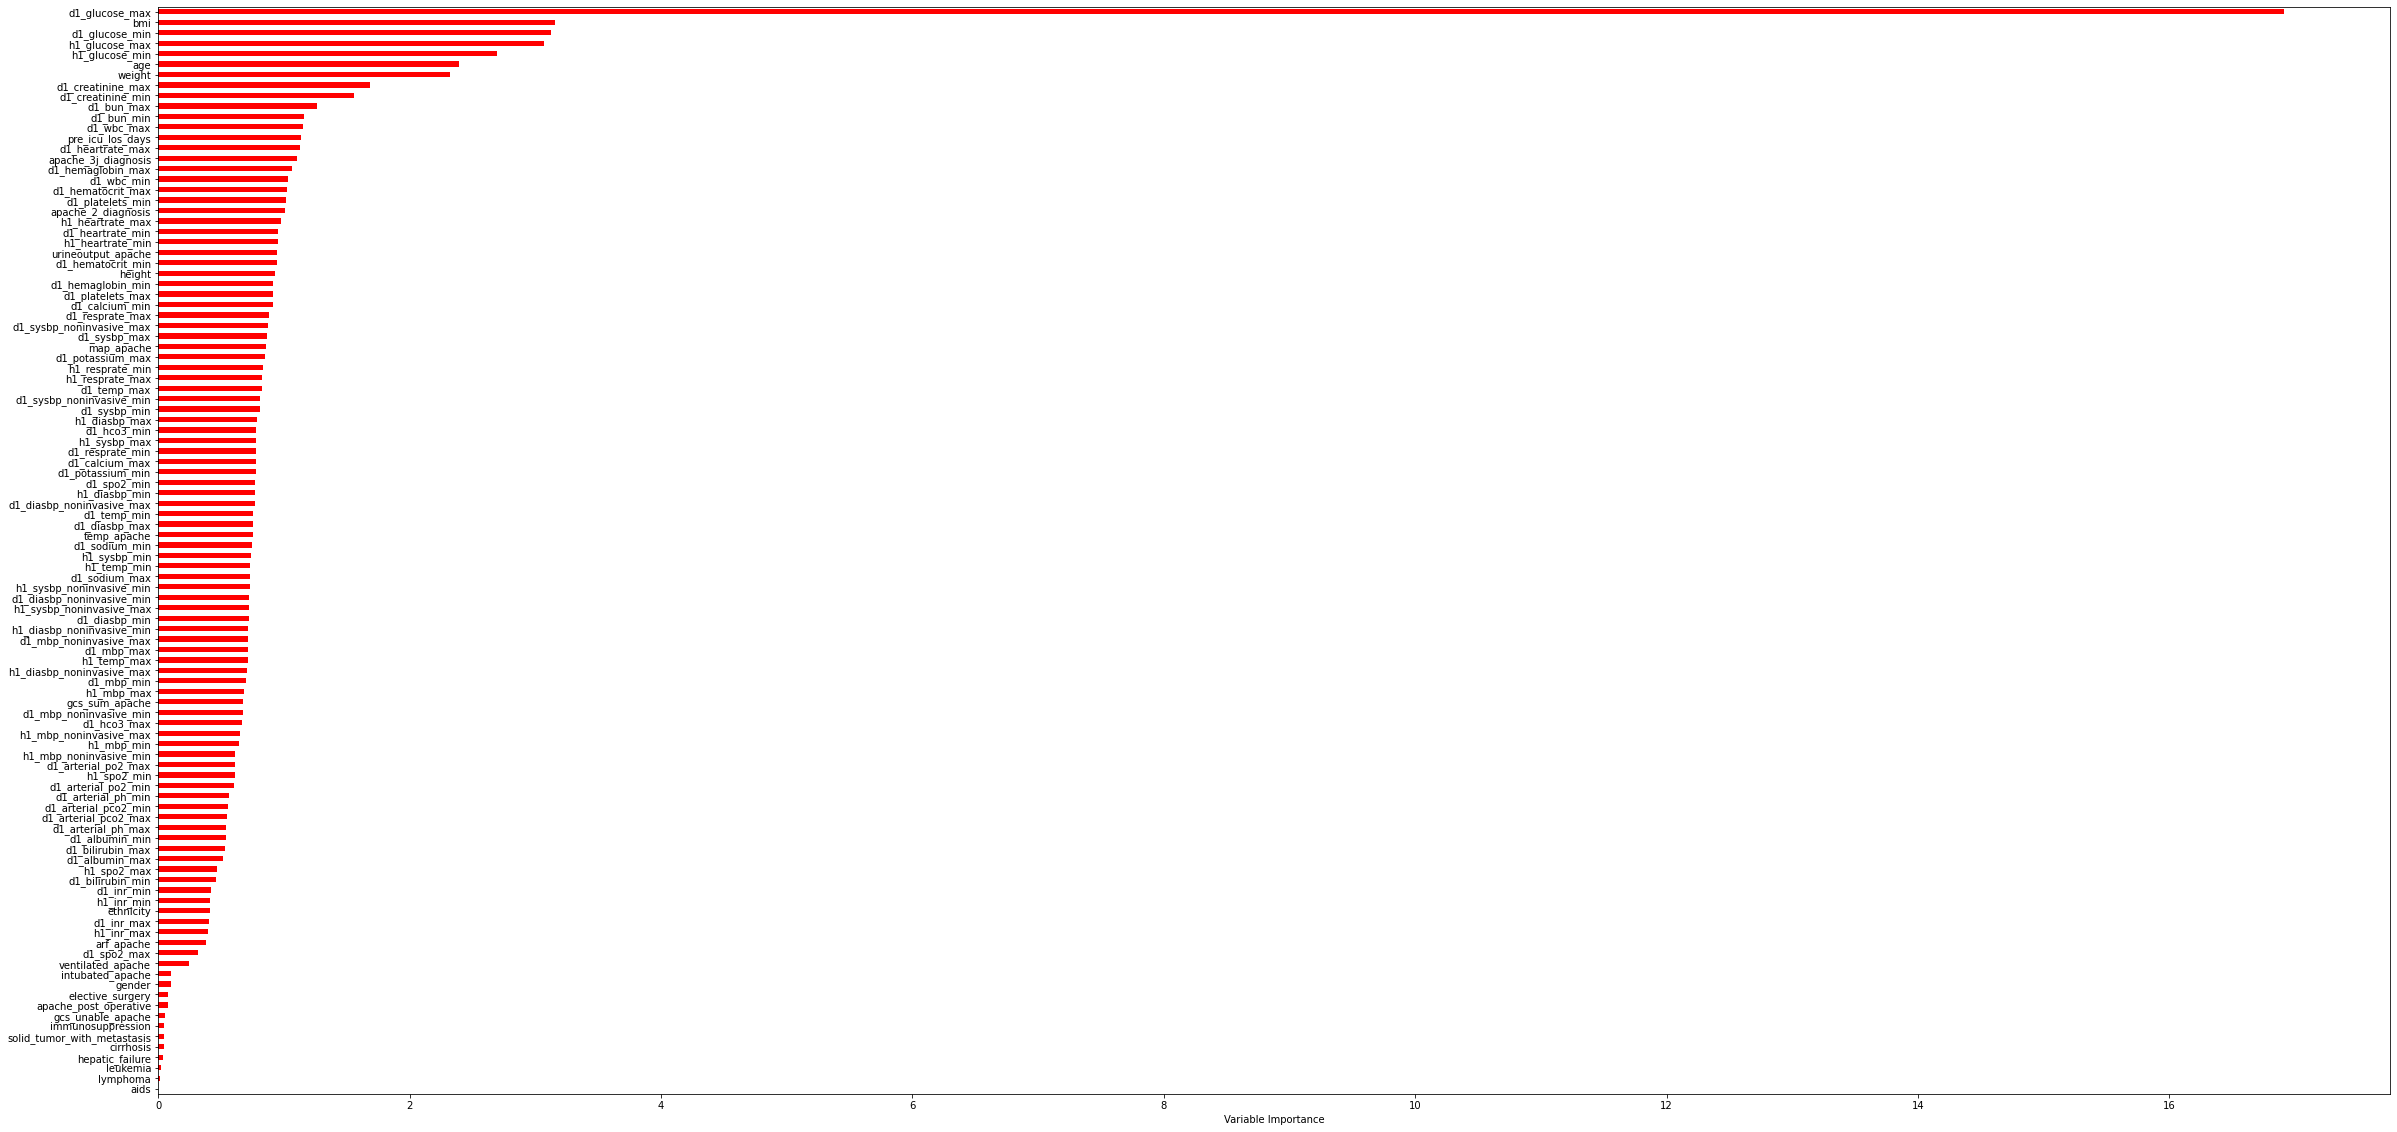

In [39]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,20)
Importance = pd.DataFrame({'Importance':classifier.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [40]:
Importance_var = Importance[Importance['Importance'] > .5]

In [41]:
WiDS_upsampled_VIF = WiDS_upsampled[['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'map_apache',
       'temp_apache', 'urineoutput_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max',
       'h1_resprate_min', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min',
       'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max',
       'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bun_max',
       'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max',
       'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max',
       'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min',
       'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'h1_glucose_max', 'h1_glucose_min', 'd1_arterial_pco2_max',
       'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min',
       'd1_arterial_po2_max', 'd1_arterial_po2_min', 'gcs_sum_apache','diabetes_mellitus']]

In [42]:
# Separate input features and target
y = WiDS_upsampled_VIF.diabetes_mellitus
x = WiDS_upsampled_VIF.drop('diabetes_mellitus', axis=1)

In [43]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

#### 5.1 Try logistic regression again with the new dataset

In [44]:
#lets start buliding the model
from sklearn.linear_model import LogisticRegression
log_reg2=LogisticRegression()

#### 5.2 Make Prediction on train data and Calculate Accuracy

In [45]:
log_reg2.fit(X_train,y_train)
pred_train=log_reg2.predict(X_train)
pd.crosstab(y_train,pred_train)

C:\Users\Abhilash\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


col_0,0,1
diabetes_mellitus,,
0,59267,17238
1,22526,53978


In [47]:
TP=53422
TN=59620
accuracy= float((TP+TN)/len(y_train))
print(accuracy)

0.7387931428870197


#### 5.3 Make Prediction on Test data and Calculate Accuracy

In [48]:
pred_test=log_reg2.predict(X_test)
pd.crosstab(y_test,pred_test)

col_0,0,1
diabetes_mellitus,,
0,19627,5874
1,7410,18092


In [49]:
TP=17850
TN=19971
accuracy= float((TP+TN)/len(y_test))
print(accuracy)

0.7415446150226457


#### Conclusion : Accuracy is very close between the 2 Model we have Build

## 6 Use XGB Classifier Algorithm to imporve the Accuracy, Use Grid search you select the best parameters 

In [50]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
param_grid = [
{'n_estimators': range(50,100,10),
'learning_rate':[.01],
'max_depth':  range(7,10,1),
'min_samples_split':[3]},
] 

gb = GridSearchCV(XGBClassifier(),
param_grid=param_grid, cv=5, scoring='roc_auc',n_jobs = -1)
gb.fit(X_train,y_train)

print(gb.best_params_)
print(gb.best_score_)

#### The best values that provide maximum accuracy,will use the same to build our model usingXGBClassifier

In [ ]:
param_grid = [
{'n_estimators': [90],
'learning_rate':[.01],
'max_depth':  [9]},
] 

gb = GridSearchCV(XGBClassifier(),
param_grid=param_grid, cv=6, scoring='roc_auc',n_jobs = -1)
gb.fit(X_train,y_train)

print(gb.best_params_)
print(gb.best_score_)

#### 6.1 Predict on Train Data And Calculate Accuracy

In [52]:
pred_train=gb.predict(X_train)
pd.crosstab(y_train,pred_train)

col_0,0,1
diabetes_mellitus,,
0,61747,14758
1,13066,63438


In [54]:
TP=63171
TN=61441
accuracy= float((TP+TN)/len(y_train))
print(accuracy)

0.8144096098922285


#### 6.2 Predict on Test Data And Calculate Accuracy

In [55]:
X_test_VIF = X_test[['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'map_apache',
       'temp_apache', 'urineoutput_apache', 'd1_diasbp_max', 'd1_diasbp_min',
       'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min',
       'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',""
       'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max',
       'h1_resprate_min', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min',
       'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max',
       'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bun_max',
       'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max',
       'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max',
       'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min',
       'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_max',
       'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min',
       'h1_glucose_max', 'h1_glucose_min', 'd1_arterial_pco2_max',
       'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min',
       'd1_arterial_po2_max', 'd1_arterial_po2_min', 'gcs_sum_apache']]

In [56]:
pred_test=gb.predict(X_test_VIF)
pd.crosstab(y_test,pred_test)

col_0,0,1
diabetes_mellitus,,
0,19772,5729
1,4798,20704


In [57]:
TP=20704
TN=19772
accuracy= float((TP+TN)/len(y_test))
print(accuracy)

0.7936003764484442
